# Imports

In [1]:
from functools import partial
import numpy as np
import os
from enum import Enum
import progressbar
from multiprocessing import Pool
from PIL import Image


# Constants

In [2]:
LOADING_BAR_LENGTH = 100

# Utils

In [3]:
def ensembleVote(integralImage, classifiers):
    # bashoof lw el votes kolaha a3la mn 0, yb2a el image face (1)
    # lw la yb2a msh face (0)
    return sum([c.getVote(integralImage) for c in classifiers]) >= 0

def ensembleVoteAll(integralImages, classifiers):
    # bn3mlha 3la kaza sora b2a w yraga3 list bt2ool kol sora face wala la

    votePartial = partial(ensembleVote, classifiers=classifiers)
    # partial dyh essentially bt3ml 'freezing' lel arguments bta3t el function
    # y3ny kda, classifiers dayman hyb2a howa el 2nd parameter. y3ny k2no 3mly
    # function esmaha votePartial, el 2nd parameter fyha byb2a classifiers, m7tag bs
    # adeeha el integralimage

    # map(votePartial, integralImages) bt3ml call lel function elly esmaha votePartial
    # 3la kol element fe el list elly esmaha integralImages. y3ny kda, el function
    # elly hyt3mlha call hyb2a votePartial(integralImages[0]), votePartial(integralImages[1])
    # votePartial(integralImages[2]) w kda 3la tool.
    # b3d kda b3ml list mn el results
    return list(map(votePartial, integralImages))

def loadImages(path):
    images = []
    for file in os.listdir(path):
        if file.endswith(".png"):
            img = np.array(Image.open((os.path.join(path, file))), dtype=np.float64)
            img /= img.max()        # normalize
            images.append(img)
    return images

# Integral Image
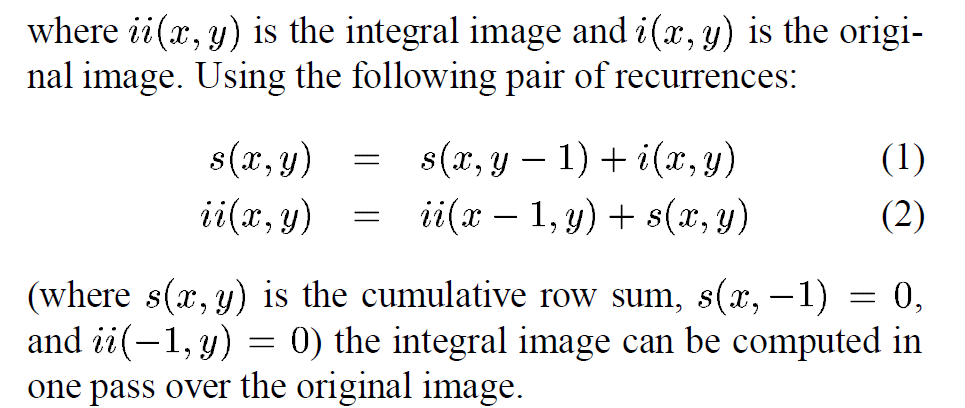

In [4]:
def createIntegralImage(img):
    # 1  2  3  4
    # 5  6  7  8
    # 9  10 11 12
    # 13 14 15 16
    
    
    # S1 S2 S3 S4
    # 1  2  3  4
    # 6  8  10 12
    # 15 18 21 24
    # 28 32 36 40  
    
    # ii 
    # 1  3  6  10
    # 6  14 24 36
    # 15 33 54 78
    # 28 60 96 136

    # Bs actually bn3ml padding, bnzawed row of zeros w column of zeros fl awl
    
    # s(x,y) = s(x,y-1) + img(x,y)
    # 7esbet el row el gdeed
    # ii(x,y) = ii(x-1,y) + s(x,y)
    # Where s(x,y) is the cumulative row sum (y3ny sum el column elly fo2ya bs)
    # s(x, -1) = 0 and ii(-1,y) = 0

    S = np.zeros((img.shape[0] + 1, img.shape[1] + 1))
    # S[0,:] = img[0,:]               # el row el awl
    # Scolumn = np.zeros(img.shape[1])   # S mo5tlfa le kol column
    for i in range(1, img.shape[0]+1):
        # Scolumn += img[i,:]          # kda kol element fl S hyb2a sum el column elly fo2o + el element nafso (aw el row nafso y3ny)
        # S[i,:] = Scolumn             # kda kol row fl S hyb2a sum el column elly fo2o + el row nafso
        S[i,1:] = S[i-1,1:] + img[i-1,:] # kda kol row fl S hyb2a sum el column elly fo2o + el row nafso

    ii = np.zeros((img.shape[0] + 1, img.shape[1] + 1))
    # ii[:,0] = S[:,0]                # el column el awl
    for i in range(1, img.shape[1]+1):
        ii[:,i] = ii[:,i-1] + S[:,i]
    return ii
    # return S

def sumRegion(integralImg, topLeft, bottomRight):
    # Calculates the sum of the rectangle using the integral image

    # badel el x,y 3lshan el bta3 actually byb2a gy 3aks el e7na mt3awdeen 3leh
    topLeft = (topLeft[1], topLeft[0])
    bottomRight = (bottomRight[1], bottomRight[0])
    topRight = (bottomRight[0], topLeft[1])
    bottomLeft = (topLeft[0], bottomRight[1])

    # 3amla zy rule P(AUB) = P(A) + P(B) - P(A n B), bs hena el 3aks b2a. fy area ethsalet mrtein
    # fa barga3 a7otaha, badal ma kanet et7atet mrtein fa barga3 ashelha
    return integralImg[bottomRight] - integralImg[topRight] - integralImg[bottomLeft] + integralImg[topLeft] 
        


In [5]:
# make a 2D matrix from 1 to 16, 4x4
img = np.arange(1,17).reshape(4,4)
print(img)
print()
ii = createIntegralImage(img)
print(ii)
print()
# 0  0  0  0  0  
# 0  1  3  6  10
# 0  6  14 24 36
# 0  15 33 54 78
# 0  28 60 96 136



[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]]

[[  0.   0.   0.   0.   0.]
 [  0.   1.   3.   6.  10.]
 [  0.   6.  14.  24.  36.]
 [  0.  15.  33.  54.  78.]
 [  0.  28.  60.  96. 136.]]



# Haar-like Features

In [6]:
class FeatureType(Enum):
    TWO_VERTICAL = (1, 2)           # etnein ta7t ba3d
    TWO_HORIZONTAL = (2, 1)         # etnein ganb ba3d
    THREE_VERTICAL = (1, 3)         # tlata ta7t ba3d
    THREE_HORIZONTAL = (3, 1)       # tlata ganb ba3d
    FOUR = (2, 2)                   # etnein w etnein zy el checkers kda


FeatureTypes = [FeatureType.TWO_VERTICAL.value, FeatureType.TWO_HORIZONTAL.value, FeatureType.THREE_VERTICAL.value, FeatureType.THREE_HORIZONTAL.value, FeatureType.FOUR.value]

# print(FeatureTypes)         #[(1, 2), (2, 1), (1, 3), (3, 1), (2, 2)]

In [7]:
class HaarLikeFeature:
    def __init__(self, featureType, position, width, height, threshold, polarity):
        self.type = featureType                                         # Type el feature (mn el Enum)
        self.topLeft = position                                         # Top left corner of the feature
        self.bottomRight = (position[0] + width, position[1] + height)  # Bottom right corner of the feature
        self.width = width                                              # Width of the feature
        self.height = height                                            # Height of the feature
        self.threshold = threshold                                      # Threshold of the feature
        self.polarity = polarity                                        # polarity of the feature (dh 3lshan mara a3ml black - white w mara el 3aks basically)
        self.weight = 1                                                 # Initial weight = 1

    def getScore(self, integralImage):
        # by7sb score el sora, el howa el black - el abyad
        black = 0
        white = 0
        if self.type == FeatureType.TWO_VERTICAL.value:
            # 2 rectangles ta7t ba3d
            black = sumRegion(integralImage, self.topLeft, (self.topLeft[0] + self.width, self.topLeft[1] + self.height//2))
            white = sumRegion(integralImage, (self.topLeft[0], self.topLeft[1] + self.height//2), self.bottomRight)
            
        elif self.type == FeatureType.TWO_HORIZONTAL.value:
            # 2 rectangles ganb ba3d
            black = sumRegion(integralImage, self.topLeft, (self.topLeft[0] + self.width//2, self.topLeft[1] + self.height))
            white = sumRegion(integralImage, (self.topLeft[0] + self.width//2, self.topLeft[1]), self.bottomRight)
            
        elif self.type == FeatureType.THREE_VERTICAL.value:
            # 3 rectangles ta7t ba3d
            black = sumRegion(integralImage, self.topLeft, (self.bottomRight[0], self.topLeft[1] + self.height//3))
            white = sumRegion(integralImage, (self.topLeft[0], self.topLeft[1] + self.height//3), (self.bottomRight[0], self.topLeft[1] + 2*self.height//3))
            black += sumRegion(integralImage, (self.topLeft[0], self.topLeft[1] + 2*self.height//3), self.bottomRight)
        
        elif self.type == FeatureType.THREE_HORIZONTAL.value:
            # 3 rectangles ganb ba3d
            black = sumRegion(integralImage, self.topLeft, (self.topLeft[0] + self.width//3, self.bottomRight[1]))
            white = sumRegion(integralImage, (self.topLeft[0] + self.width//3, self.topLeft[1]), (self.topLeft[0] + 2*self.width//3, self.bottomRight[1]))
            black += sumRegion(integralImage, (self.topLeft[0] + 2*self.width//3, self.topLeft[1]), self.bottomRight)
        
        elif self.type == FeatureType.FOUR.value:
            # 4 rectangles zy el checkers
            # el top left rectangle
            black = sumRegion(integralImage, self.topLeft, (self.topLeft[0] + self.width//2, self.topLeft[1] + self.height//2))
            # el top right rectangle
            white = sumRegion(integralImage, (self.topLeft[0] + self.width//2, self.topLeft[1]), (self.bottomRight[0], self.topLeft[1] + self.height//2))
            # el bottom left rectangle
            white += sumRegion(integralImage, (self.topLeft[0], self.topLeft[1] + self.height//2), (self.topLeft[0] + self.width//2, self.bottomRight[1]))
            # el bottom right rectangle
            black += sumRegion(integralImage, (self.topLeft[0] + self.width//2, self.topLeft[1] + self.height//2), self.bottomRight)
        return black - white
    
    def getVote(self, integralImage):
        # by7sb el vote
        # print("hal btewsal hena?")
        score = self.getScore(integralImage)
        # return self.weight * (1 if score < self.polarity * self.threshold else -1)
        # return +ve weight lw score < polarity * threshold
        # return -ve weight lw score >= polarity * threshold
        # return self.weight * ((score < self.polarity * self.threshold) - (score >= self.polarity * self.threshold))
        if score < self.polarity * self.threshold:
            return self.weight
        return -self.weight
    

# AdaBoost
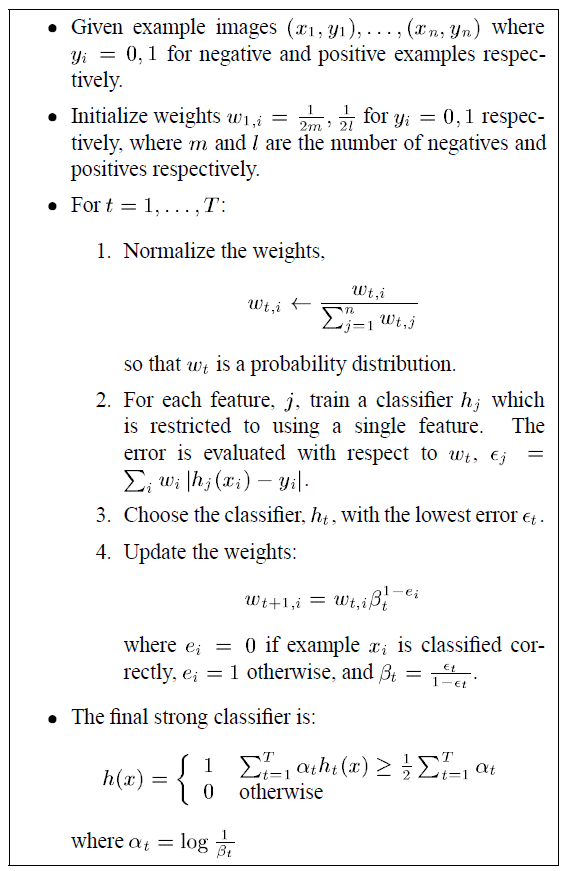

In [8]:
def getFeatureVote(feature, integralImage):
    # print("getFeatureVote eshta")
    return feature.getVote(integralImage)

def createFeatures(imgHeight, imgWidth, minFeatureWidth, maxFeatureWidth, minFeatureHeight, maxFeatureHeight):
    print("Creating Haar-like features...")
    features = []
    for feature in FeatureTypes:
        # FeatureTypes dh el tuples el 3mlnaha fl enum
        featureStartWidth = max(minFeatureWidth, feature[0])       # el width elly haybda2 menha el feature
        for featurewidth in range(featureStartWidth, maxFeatureWidth, feature[0]):
            # starts from featureStartWidth, ends at maxFeatureWidth, increments by feature[0]
            # el increment kda by5aly mfeesh overlap
            featureStartHeight = max(minFeatureHeight, feature[1])
            for featureHeight in range(featureStartHeight, maxFeatureHeight, feature[1]):
                # nafs kalam el width
                # el overlap bye7sal bsbb el 7eta el gya dyh b2a, l2ny b3ady 3la kol pixel 7rfyn agrb el feature dyh
                for x in range(imgWidth - featurewidth):        # ba2of hena 3lshan el feature mtetla3sh bara el sora y3ny
                    for y in range(imgHeight - featureHeight):
                        # (feature_type, position, width, height, threshold, polarity) dol el parameters
                        # badeelo el polarity mara +ve w mara -ve 3lshan yb2a mara black - white w mara el 3aks
                        features.append(HaarLikeFeature(feature, (x,y), featurewidth, featureHeight, 0, 1))
                        features.append(HaarLikeFeature(feature, (x,y), featurewidth, featureHeight, 0, -1))
    print(f"Done creating {len(features)} Haar-like features.\n")
    return features


def learn(faceIntegralImages, nonFaceIntegralImages, numClassifiers=-1, minFeatureWidth=1, maxFeatureWidth=-1, minFeatureHeight=1, maxFeatureHeight=-1):
    # dh el bye5tar el classifier, w kol shwya y5tar a7sn wa7ed w kda
    # faceIntegralImages: list of integral images of faces
    # nonFaceIntegralImages: list of integral images of non faces
    # numClassifiers: number of classifiers, -1 y3ny esta3melhom kolohom
    # minFeatureWidth: minimum width of the features
    # maxFeatureWidth: maximum width of the features, -1 y3ny esta3mel el sora kolha
    # minFeatureHeight: minimum height of the features
    # maxFeatureHeight: maximum height of the features, -1 y3ny esta3mel el sora kolha

    numFaces = len(faceIntegralImages)
    numNonFaces = len(nonFaceIntegralImages)
    numImages = numFaces + numNonFaces
    imgHeight, imgWidth = faceIntegralImages[0].shape   # kol el sowar 3ndhom nafs el size kda kda

    # maxFeatureHeigh = imgHeight * (maxFeatureHeight == -1) + maxFeatureHeight * (maxFeatureHeight != -1)
    maxFeatureHeight = imgHeight if maxFeatureHeight == -1 else maxFeatureHeight
    maxFeatureWidth = imgWidth if maxFeatureWidth == -1 else maxFeatureWidth

    # Initializing weights
    posWeights = np.ones(numFaces) * 1.0 / (2 * numFaces)       # badrab fy 1.0 3lshan yb2a float
    negWeights = np.ones(numNonFaces) * 1.0 / (2 * numNonFaces)
    weights = np.concatenate((posWeights, negWeights))          # kol el weights fl array dh, el +ve b3d kda el -ve
    labels = np.concatenate((np.ones(numFaces), -np.ones(numNonFaces)))   # el +ve bya5do 1 w el -ve bya5do -1

    images = faceIntegralImages + nonFaceIntegralImages         # dh kda by-concatenate el 2 lists
                                                                # faceIntegralImages = [np.array1, np.array2, ...]
                                                                # nonFaceIntegralImages = [np.array1, np.array2, ...]
                                                                # images = [np.array1, np.array2, ..., np.array1, np.array2, ...] (7at el etnein wara ba3d)
    
    # hn3ml el features b2a b kol el sizes wl locations
    features = createFeatures(imgHeight, imgWidth, minFeatureWidth, maxFeatureWidth, minFeatureHeight, maxFeatureHeight)
    numFeatures = len(features)
    featureIndicies = list(range(numFeatures))

    # ba5od el max number of classifiers lw numClassifiers = -1, 8eir kda ba5od el rakam dh bs
    numClassifiers = numFeatures if numClassifiers == -1 else numClassifiers
    
    print("Calculating scores for each feature...")

    votes = np.zeros((numImages, numFeatures))
    # vote le kol feature 3la kol sora
    bar = progressbar.ProgressBar(maxval = LOADING_BAR_LENGTH)
    # 8albn max_value dh hy3ml kam bar y3ny (el default 50 bayen)

    pool = Pool(processes=None)
    # kda hyst5dm el default number of processes available fl system
    # print("features length: ", len(features))
    # print("awl 10 Features: ", features[:10])
    for i in bar(range(numImages)):
        # print("tab hal asln btewsal hena?")     # eshta byewsal ah
        # votes[i, :] = np.array(list(pool.map(partial(getFeatureVote, integralImage=images[i]), features)))    # pooling 3amla moshkela for some reason ;-;
        votes[i, :] = np.array(list(map(partial(getFeatureVote, integralImage=images[i]), features)))
        # kda by-parallelize el function bta3t getFeatureVote y3ny

    # hne5tar a7sn classifiers b2a
    print("Selecting classifiers...")
    classifiers = []
    bar = progressbar.ProgressBar(maxval = LOADING_BAR_LENGTH)
    
    for _ in bar(range(numClassifiers)):
        classificationErrors = np.zeros(len(featureIndicies))

        # normalize el weights
        weights *= 1. / np.sum(weights)     # badrab fy 1.0 3lshan yb2a float

        # hne5tar a7sn classifier mn el weighted error
        for f in range(len(featureIndicies)):
            featureIndex = featureIndicies[f]
            # el error howa el sum bta3 el image weights elly howa 8elet fyha
            error = sum(map(lambda imgIdx: weights[imgIdx] if labels[imgIdx] != votes[imgIdx, featureIndex] else 0, range(numImages)))
            classificationErrors[f] = error

        # hnshoof meen 3ndo a2al error, dh a7sn feature
        minErrorIndex = np.argmin(classificationErrors)     # btraga3 index as8ar wa7ed
        bestError = classificationErrors[minErrorIndex]
        bestFeatureIndex = featureIndicies[minErrorIndex]


        # updating el weights
        weights = np.array(list(map(lambda imgIdx: weights[imgIdx] if labels[imgIdx] != votes[imgIdx, bestFeatureIndex] else
                                                   weights[imgIdx] * (bestError / (1 - bestError)), range(numImages))))
        
        # hn7ot weight el feature
        bestFeature = features[bestFeatureIndex]
        bestFeature.weight = 0.5 * np.log((1 - bestError) / bestError)
        classifiers.append(bestFeature)

        # sheel el feature b2a 5las, 3lshan mnerga3sh ne5tarha tany
        featureIndicies.remove(bestFeatureIndex)

    return classifiers
        


    



In [9]:
# X is a list from 1 to 3
# Y is a list from 4 to 6
X = np.ones(2) * 2
Y = np.ones(4) * 3
Z = np.hstack((X,Y))
Z2 = np.concatenate((X,Y))
print(Z)
print(Z2)
print(X, Y)

[2. 2. 3. 3. 3. 3.]
[2. 2. 3. 3. 3. 3.]
[2. 2.] [3. 3. 3. 3.]


In [10]:
print(f"Done creating {len(X)} Haar-like features.\n")

Done creating 2 Haar-like features.



In [11]:
pos_training_path = 'Dataset3/faces/'
neg_training_path = 'Dataset3/nonfaces/'
pos_testing_path = 'Dataset3/faces/test/'
neg_testing_path = 'Dataset3/nonfaces/test/'

numClassifiers = 20
minFeatureHeight = 4
maxFeatureHeight = 10
minFeatureWidth = 4
maxFeatureWidth = 10


In [12]:
facesTraining = loadImages(pos_training_path)
facesTrainingIntegral = list(map(createIntegralImage, facesTraining))
print(f"...Loaded {len(facesTraining)} faces training images.")

nonFacesTraining = loadImages(neg_training_path)
nonFacesTrainingIntegral = list(map(createIntegralImage, nonFacesTraining))
print(f"...Loaded {len(nonFacesTraining)} non faces training images.")

facesTesting = loadImages(pos_testing_path)
facesTestingIntegral = list(map(createIntegralImage, facesTesting))
print(f"...Loaded {len(facesTesting)} faces testing images.")

nonFacesTesting = loadImages(neg_testing_path)
nonFacesTestingIntegral = list(map(createIntegralImage, nonFacesTesting))
print(f"...Loaded {len(nonFacesTesting)} non faces testing images.")


...Loaded 131 faces training images.
...Loaded 171 non faces training images.
...Loaded 122 faces testing images.
...Loaded 137 non faces testing images.


In [13]:
classifiers = learn(facesTrainingIntegral, nonFacesTrainingIntegral, numClassifiers, minFeatureWidth, maxFeatureWidth, minFeatureHeight, maxFeatureHeight)


Creating Haar-like features...
Done creating 26532 Haar-like features.

Calculating scores for each feature...


100% |########################################################################|


Selecting classifiers...


100% |########################################################################|


In [14]:
print('Testing selected classifiers...')
correctFaces = sum(ensembleVoteAll(facesTestingIntegral, classifiers))
correctNonFaces = len(nonFacesTestingIntegral) - sum(ensembleVoteAll(nonFacesTestingIntegral, classifiers))
print(f"Correct faces: {correctFaces}/{len(facesTestingIntegral)}\t ({correctFaces/len(facesTestingIntegral)*100}%)")
print(f"Correct non faces: {correctNonFaces}/{len(nonFacesTestingIntegral)}\t ({correctNonFaces/len(nonFacesTestingIntegral)*100}%)")

Testing selected classifiers...
Correct faces: 33/122	 (27.049180327868854%)
Correct non faces: 92/137	 (67.15328467153284%)
